<a href="https://colab.research.google.com/github/seichikk/linallab/blob/main/Linal_lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа №1. Principle Component Analysis**
**Выполнили:**  
- Марковский Артём Владиславович, ИСУ: 466636, группа J3110  
- Бровкин Аким Алексеевич , ИСУ: 465282, группа J3110  



---



#**Класс матриц для удобства**

In [ ]:
import random
import math
import csv
from typing import List, Union, Callable, Tuple, Dict, Any
from math import isclose
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from math import isnan
from IPython.display import display
from matplotlib.figure import Figure
class Matrix:

    def __init__(self, data: List[List[float]]):
        self.rows = len(data)
        self.cols = len(data[0]) if self.rows > 0 else 0
        self.data = data
        self._validate()

    def _validate(self):
        """Проверка корректности размеров"""
        for row in self.data:
            if len(row) != self.cols:
                raise ValueError("Некорректные размеры матрицы")

    def __getitem__(self, index):
        return self.data[index]

    def __repr__(self):
        return "\n".join(["\t".join(map("{:.4f}".format, row)) for row in self.data])

    def copy(self):
        """Глубокая копия матрицы"""
        return Matrix([row.copy() for row in self.data])

    def swap_rows(self, row1: int, row2: int):
        """Перестановка строк"""
        self.data[row1], self.data[row2] = self.data[row2], self.data[row1]

    def normalize_row(self, row: int, pivot_col: int):
        """Нормировка строки по ведущему элементу"""
        pivot = self[row][pivot_col]
        self.data[row] = [x / pivot for x in self[row]]

    def subtract_row(self, target_row: int, source_row: int, factor: float):
        """Вычитание строки с коэффициентом"""
        self.data[target_row] = [x - factor * self[source_row][i] for i, x in enumerate(self[target_row])]

    def transpose_data(self):
      """Транспозиция матрицы"""
      transposed = []
      for i in range(self.cols):
        temporary = []
        for j in range(self.rows):
          temporary.append(self.data[j][i])
        transposed.append(temporary)
      return Matrix(transposed)

    def multiply(self, other: 'Matrix') -> 'Matrix':
        """Умножение матриц"""
        if not isinstance(other, Matrix):
            raise TypeError("Можно умножать только на объект Matrix")
        if self.cols != other.rows:
            raise ValueError(
                "Несовместимые размеры"
            )

        result_data = []
        for i in range(self.rows):
            row = []
            for j in range(other.cols):
                element = sum(
                    self.data[i][k] * other.data[k][j]
                    for k in range(self.cols)
                )
                row.append(element)
            result_data.append(row)

        return Matrix(result_data)

    def multiply_scalar(self, scalar: Union[int, float]) -> 'Matrix':
        """Умножение матрицы на скаляр"""
        if not isinstance(scalar, (int, float)):
            raise TypeError("Скаляр должен быть int или float")

        new_data = [
            [element * scalar for element in row]
            for row in self.data
        ]
        return Matrix(new_data)

    def minor(self, k: int):
      """Вычисление минора матрицы"""
      res = []
      for r in self.data[1:]:
        row = []
        for j in range(len(r)):
          if j != k:
            row.append(r[j])
        res.append(row)
      return res

    def determinant(self):
      """Вычисление определителя матрицы"""
      n = self.rows
      if n == 2:
        return self.data[0][0] * self.data[1][1] - self.data[0][1] * self.data[1][0]
      det = 0
      sign = 1
      for i in range(n):
        det += sign * self.data[0][i] * Matrix(self.minor(i)).determinant()
        sign = -sign
      return det

    def add(self, other: 'Matrix') -> 'Matrix':
      """Поэлементное сложение матриц."""
      if self.rows != other.rows or self.cols != other.cols:
          raise ValueError("Матрицы должны быть одного размера")
      new_data = [
          [self.data[i][j] + other.data[i][j] for j in range(self.cols)]
          for i in range(self.rows)
      ]
      return Matrix(new_data)

    def __sub__(self, other: 'Matrix') -> 'Matrix':
      """Вычитание матриц"""
      if not isinstance(other, Matrix):
          raise TypeError("Можно вычитать только объекты Matrix")
      if self.rows != other.rows or self.cols != other.cols:
          raise ValueError("Матрицы должны быть одного размера")
      new_data = [
          [self.data[i][j] - other.data[i][j] for j in range(self.cols)]
          for i in range(self.rows)
      ]
      return Matrix(new_data)

    @staticmethod
    def identity(n: int) -> 'Matrix':
      """Создание единичной матрицы"""
      data = [[1.0 if i == j else 0.0 for j in range(n)] for i in range(n)]
      return Matrix(data)

    def characteristic_polynomial(self) -> Callable[[float], float]:
      """Характеристический многочлен"""
      if self.rows != self.cols:
          raise ValueError("Характеристический многочлен определен только для квадратных матриц")
      E = Matrix.identity(self.rows)
      def poly(x: float) -> float:
          lambda_E = E.multiply_scalar(x)
          A_minus_lambda_E = self - lambda_E
          return A_minus_lambda_E.determinant()
      return poly

    def _std(self) -> float:
      """Стандартное отклонение"""
      if self.cols != 1:
          raise ValueError("Стандартное отклонение определено только для векторов-столбцов")
      values = [self.data[i][0] for i in range(self.rows)]
      n = len(values)
      mean = sum(values) / n
      variance = sum((x - mean) ** 2 for x in values) / (n - 1)
      return math.sqrt(variance)

# **Реализация метода Гаусса для решения СЛАУ**

In [ ]:
def gauss_solver(A: Matrix, b: Matrix) -> List[Matrix]:
    """Метод гауса для решения Ax = b"""
    # Проверка размеров
    if A.rows != b.rows or b.cols != 1:
        raise ValueError("Данные введены неверно")

    # Создаем расширенную матрицу [A|b]
    aug_data = [A_row + b_row for A_row, b_row in zip(A.data, b.data)]
    aug = Matrix(aug_data)
    aug = aug.copy()  # Работаем с копией, чтобы не менять исходные данные

    pivot_cols = []  # Список ведущих столбцов
    rank = 0        # Ранг матрицы

    # Преобразование к ступенчатому виду
    for col in range(A.cols):
        # Поиск максимального элемента в текущем столбце (для минимизации ошибок)
        max_row, max_val = None, 0.0
        for row in range(rank, aug.rows):
            current_val = abs(aug[row][col])
            if current_val > max_val:
                max_val = current_val
                max_row = row

        # Если все элементы в столбце нулевые, то пропускаем столбец
        if max_row is None or isclose(max_val, 0, abs_tol=1e-10):
            continue

        # Перестановка строк (ставим строку с максимальным элементом наверх)
        aug.swap_rows(rank, max_row)

        # Нормировка строки (делаем ведущий элемент равным 1)
        aug.normalize_row(rank, col)

        # Обнуление элементов под ведущим
        for row in range(rank + 1, aug.rows):
            factor = aug[row][col]  # Коэффициент для вычитания
            aug.subtract_row(row, rank, factor)

        pivot_cols.append(col)  # Запоминаем ведущий столбец
        rank += 1               # Увеличиваем ранг

    # Проверка на совместность системы
    # Если есть строка [0, 0, ..., 0 | c], где c ≠ 0 -> система несовместна
    for row in range(rank, aug.rows):
        if not isclose(aug[row][-1], 0, abs_tol=1e-8):
            raise ValueError("Система не имеет решений")

    # Обнуление элементов над ведущими
    for i in reversed(range(rank)):
        col = pivot_cols[i]
        for row in range(i):
            factor = aug[row][col]
            aug.subtract_row(row, i, factor)

    # Построение решений
    free_vars = [c for c in range(A.cols) if c not in pivot_cols]  # Свободные переменные

    # Частное решение (все свободные переменные = 0)
    particular = [0.0] * A.cols
    for i in range(rank):
        particular[pivot_cols[i]] = aug[i][-1]

    # Если нет свободных переменных -> единственное решение
    if not free_vars:
        return [Matrix([particular])]

    # Базисные векторы для свободных переменных
    basis = []
    for free in free_vars:
        vec = [0.0] * A.cols
        vec[free] = 1.0  # Свободная переменная = 1
        # Выражаем базисные переменные через свободные
        for i in range(rank):
            vec[pivot_cols[i]] = -aug[i][free]
        basis.append(Matrix([vec]))

    return [Matrix([particular])] + basis

# **Пример с единственным решением**

In [ ]:
# Создаем матрицы
A = Matrix([[3,2,-1],
           [2,-1,5],
           [1,7,-1]
])
b = Matrix([[4],[23],[5]])

# Решаем систему
try:
    solutions = gauss_solver(A, b)
    print("Частное решение:")
    print(solutions[0])
    if len(solutions) > 1:
      print("\nБазисные векторы:")
      for vec in solutions[1:]:
          print(vec)
except ValueError as e:
    print(e)

Частное решение:
2.0000	1.0000	4.0000


# **Пример, где нет решений**

In [ ]:
# Создаем матрицы
A = Matrix([
    [3, 2, -1],
    [2, -1, 5],
    [2, -1, 5]
])
b = Matrix([[4], [23], [24]])

# Решаем систему
try:
    solutions = gauss_solver(A, b)
    print("Частное решение:")
    print(solutions[0])
    if len(solutions) > 1:
      print("\nБазисные векторы:")
      for vec in solutions[1:]:
          print(vec)
except ValueError as e:
    print(e)

Система не имеет решений


# **Пример, где решений бесконечное множество**

In [ ]:
# Создаем матрицы
A = Matrix([
    [2, -1, 5],
    [2, -1, 5],
    [2, -1, 5]
])
b = Matrix([[23], [23], [23]])

# Решаем систему
try:
    solutions = gauss_solver(A, b)
    print("Частное решение:")
    print(solutions[0])
    if len(solutions) > 1:
      print("\nБазисные векторы:")
      for vec in solutions[1:]:
          print(vec)
except ValueError as e:
    print(e)

Частное решение:
11.5000	0.0000	0.0000

Базисные векторы:
0.5000	1.0000	0.0000
-2.5000	0.0000	1.0000


# **Реализация функции центрирования данных**

In [ ]:
def center_data(A: Matrix) -> Matrix:
    # Определяем признаки, как транспонированную матрицу
    features = A.transpose_data()
    means = []
    # Заполняем массив средних по формуле среднего арифметического
    for feature_row in features.data:
        mean = sum(feature_row) / len(feature_row)
        means.append(mean)
    # Создаем копию признаков
    centered_features = features.copy()
    for i in range(centered_features.rows):
        for j in range(centered_features.cols):
          # Вычитаем из каждого элемента соответствующее среднее
            centered_features.data[i][j] -= means[i]
    return centered_features.transpose_data()

# **Пример центрирования данных матрицы**

In [ ]:
B = Matrix([[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9],
     [10, 11, 12]])

print(center_data(B))

-4.5000	-4.5000	-4.5000
-1.5000	-1.5000	-1.5000
1.5000	1.5000	1.5000
4.5000	4.5000	4.5000


# **Реализация функции вычисления матрицы ковариаций**

In [ ]:
def covariance_matrix(X_centered: 'Matrix') -> 'Matrix':
  # Определяем число n, как количество строк
  n = X_centered.rows
  if n == 1:
    raise ValueError("Матрица должна иметь больше одной строки")
  # Вычисляем транспонированную матрицу
  X_T = X_centered.transpose_data()
  # Умножаем слева транспонированную матрицу на исходную
  X_TX = X_T.multiply(X_centered)

  covariated = X_TX.multiply_scalar(1 / (n - 1))
  return covariated

# **Пример вычисленной матрицы ковариаций**

In [ ]:
# Центрированная матрица C
C = center_data(Matrix([[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9],
     [10, 11, 12]]))

print(covariance_matrix(C))

15.0000	15.0000	15.0000
15.0000	15.0000	15.0000
15.0000	15.0000	15.0000


# **Пример, когда матрицы ковариаций не существует (количество строк равно 1)**

In [ ]:
# Инициализация центрированной матрицы 1x1
N = center_data(Matrix([[4]]))

try:
  print(covariance_matrix(N))
except ValueError as e:
  print(e)

Матрица должна иметь больше одной строки


# **Реализация функции поиска собственных значений методом бисекции**

In [ ]:
# Функция для поиска интервала, в котором лежат собственные значения
def find_interval(C: 'Matrix') -> List[float]:
    n = C.rows

    # Вычисляем максимальную сумму абсолютных значений недиагональных элементов по строкам
    r = max([sum(abs(C[i][j]) for j in range(n) if i != j) for i in range(n)])

    # Находим минимальное и максимальное значения диагональных элементов
    d_min = min(C[i][i] for i in range(n))
    d_max = max(C[i][i] for i in range(n))

    # Вычисляем нижнюю и верхнюю границы интервала для собственных значений
    min_lambda = d_min - r
    max_lambda = d_max + r

    return [min_lambda, max_lambda]

# Функция поиска собственных значений
def find_eigenvalues(C: 'Matrix', tol: float = 1e-7) -> List[float]:
    poly = C.characteristic_polynomial()

    eigenvalues = []

    interval = find_interval(C)

    start = interval[0]  # Начало интервала
    step = (interval[1] - interval[0]) / 6666  # Делим интервал на 6666 частей для поиска

    while start < interval[1]:
        left = start  # Левая граница текущего отрезка
        right = start + step  # Правая граница текущего отрезка
        start += step

        # Проверяем, есть ли корень на отрезке [left, right]
        if poly(left) * poly(right) > 0:
            continue  # Если знаки совпадают, корня нет, переходим к следующему отрезку

        # Метод бисекции
        while (right - left) / 2 > tol:
            mid = (left + right) / 2
            if poly(mid) == 0:
                break
            if poly(mid) * poly(right) < 0:
                left = mid
            else:
                right = mid

        eigenvalues.append(round((left + right) / 2, 6))

    eigenvalues = [round(i, 6) for i in eigenvalues]

    if 0 not in eigenvalues and poly(0) == 0:
        eigenvalues.append(0)

    return sorted(eigenvalues, reverse=True)

# **Пример поиска собственных значений**

In [ ]:
# Инициализация матрицы
F = Matrix([[1, 2, 3], [4, 5, 6], [7, 8, -9]])

print(find_eigenvalues(F))

[10.059332, -0.424882, -12.63445]


# **Пример для неквадратной матрицы**

In [ ]:
# Инициализация неквадратной матрицы
D = Matrix([[1, 2, 3, 4], [5, 6, 7, 8]])
try:
  print(find_eigenvalues(D))
except ValueError as e:
  print(e)

Характеристический многочлен определен только для квадратных матриц


# **Собственные векторы матрицы С**

In [ ]:
def find_eigenvectors(C: Matrix, eigenvalues: List[float]) -> List[Matrix]:
    eigenvectors = []
    m = C.rows
    for lambda_ in eigenvalues:
        # Создаем матрицу (C - λI)
        I = Matrix.identity(m)
        lambda_I = I.multiply_scalar(lambda_)
        C_minus_lambdaI = C - lambda_I

        # Нулевой вектор правой части (m x 1)
        zero_b = Matrix([[0.0] for _ in range(m)])

        try:
            # Решаем систему (C - λI)v = 0
            solutions = gauss_solver(C_minus_lambdaI, zero_b)
        except ValueError:
            # Теоретически, для собственных значений система должна быть совместной
            continue  # Пропускаем, если возникла ошибка (например, погрешности)

        # Базисные векторы (решения) начинаются с индекса 1 так как нулевой вектор скип
        for solution in solutions[1:]:
            # Преобразуем вектор-строку в вектор-столбец
            vec = solution.transpose_data()
            eigenvectors.append(vec)

    return eigenvectors

# **Пример нахождения собственных векторов**

In [ ]:
C = Matrix([[1, 0, 0, 0, 0], [0, 2, 0, 0, 0], [0, 0, 3, 0, 0], [0, 0, 0, 4, 0], [0, 0, 0, 0, 5]])
eigenvalues = find_eigenvalues(C)
eigenvectors = find_eigenvectors(C, eigenvalues)

print("Собственные значения:", eigenvalues)
print("Собственные векторы:")
for vec in eigenvectors:
    print(vec)
    print()
print(len(eigenvectors))

Собственные значения: [5.0, 4.0, 3.0, 2.0, 1.0]
Собственные векторы:
0.0000
0.0000
0.0000
0.0000
1.0000

-0.0000
-0.0000
-0.0000
1.0000
-0.0000

-0.0000
-0.0000
1.0000
-0.0000
-0.0000

-0.0000
1.0000
-0.0000
-0.0000
-0.0000

1.0000
-0.0000
-0.0000
-0.0000
-0.0000

5


#**Доля объясненной дисперсии**

In [ ]:
def explained_variance_ratio(eigenvalues: List[float], k: int) -> float:
    #Доля объясненной дисперсии
    if not eigenvalues:
        raise ValueError("Список eigenvalues не может быть пустым")
    if k < 1 or k > len(eigenvalues):
        raise ValueError(f"k должно быть от 1 до {len(eigenvalues)}")

    # Сумма первых k собственных значений
    sorted_eigenvalues = sorted(eigenvalues, reverse=True)
    sum_top_k = sum(sorted_eigenvalues[:k])
    # Общая сумма всех собственных значений
    total_sum = sum(sorted_eigenvalues)

    if total_sum == 0:
        return 0.0  # Если все eigenvalues нулевые

    return round(sum_top_k / total_sum, 6)

#**Пример поиска доли объясненной дисперсии**

In [ ]:
eigenvalues = [4.0, 3.0, 2.0]
print(explained_variance_ratio(eigenvalues, 2))  # (4+3)/(4+3+2) = 7/9

0.7777777777777778


In [ ]:
eigenvalues = [4.0, 3.0, 2.0]
try:
  print(explained_variance_ratio(eigenvalues, 4))
except ValueError as e:
  print(e)

k должно быть от 1 до 3


#**FULL алгоритм PCA (с автоматическим выбором k)**

In [ ]:
def auto_select_k(eigenvalues: List[float], threshold: float = 0.95) -> int:
    """
    Автоматически выбирает k так, чтобы объясненная дисперсия была >= threshold.
    Использует функцию `explained_variance_ratio` для расчетов, избегая дублирования кода.
    """
    if not eigenvalues:
        return 0  # Пустой список -> 0 компонент

    # Проверка на нулевую дисперсию
    total_sum = sum(eigenvalues)
    if total_sum == 0:
        return 0

    # Перебираем k от 1 до m, пока не достигнем порога
    for k in range(1, len(eigenvalues) + 1):
        current_ratio = explained_variance_ratio(eigenvalues, k)
        if current_ratio >= threshold:
            return k

    # Если порог не достигнут, возвращаем все компоненты
    return len(eigenvalues)

#**Примеры автоматического выбора k**

In [ ]:
eigenvalues1 = [3.0, 2.0, 1.0, 0.5]
k1 = auto_select_k(eigenvalues1, threshold=0.95) # Базовый случай
eigenvalues2 = [10.0, 1.0, 0.1, 0.01]
k2 = auto_select_k(eigenvalues2, threshold=0.95) # Порог достигается рано
eigenvalues3 = [1.0, 1.0, 1.0]
k3 = auto_select_k(eigenvalues3, threshold=0.99) # Все компоненты нужны
print(f"k1 = {k1}")
print(f"k2 = {k2}")
print(f"k3 = {k3}")

k1 = 4
k2 = 2
k3 = 3


In [ ]:
def pca(X: 'Matrix', k: int = None, threshold: float = 0.95) -> Tuple['Matrix', float, 'Matrix']:
    X_centered = center_data(X)
    C = covariance_matrix(X_centered)
    eigenvalues = find_eigenvalues(C)
    eigenvectors = find_eigenvectors(C, eigenvalues)
    num_eigenvectors = len(eigenvectors)
    print("eigenvalues", eigenvalues)
    print("eigenvectors", eigenvectors)
    print(C)
    if k is None:
        sorted_eigenvalues = sorted(eigenvalues, reverse=True)
        selected_k = auto_select_k(sorted_eigenvalues, threshold)
    else:
        if k < 1 or k > len(eigenvalues):
            raise ValueError(f"k должно быть от 1 до {len(eigenvalues)}")
        selected_k = k
    print("sel_k1", selected_k)
    print("sel_k2", selected_k)
    # Нормализация собственных векторов
    for vec in eigenvectors:
        # Вычисление нормы (длины) вектора
        norm = sum(x**2 for row in vec.data for x in row) ** 0.5
        if norm == 0:
            raise ValueError("Нулевой собственный вектор")
        # Нормировка каждого элемента вектора
        vec.data = [[x / norm for x in row] for row in vec.data]

    feats = X.cols
    W_data = []
    for i in range(feats):
        row = []
        for j in range(selected_k):
            if len(eigenvectors[j].data) == 1:
              row.append(eigenvectors[j].data[0][i])
            else:
              row.append(eigenvectors[j].data[i][0])
        W_data.append(row)
    W = Matrix(W_data)

    X_proj = X_centered.multiply(W)
    explained_variance = explained_variance_ratio(eigenvalues, selected_k)

    return (X_proj, explained_variance, W)

#**Пример работы алгоритма РСА**

In [ ]:
X = Matrix([[14, 88], [13, 37]])
# PCA для автоматически выбранного k
X_proj, variance_ratio, _ = pca(X, k=None)

print("Проекция данных:")
print(X_proj)
print(f"\nДоля объясненной дисперсии: {variance_ratio}")

Проекция данных:
25.5049
-25.5049

Доля объясненной дисперсии: 1.0


In [ ]:
def plot_pca_projection(X_proj: 'Matrix') -> Figure:
  # Фигура и оси
  fig = Figure(figsize=(8, 6))
  ax = fig.add_subplot(111)

  num_components = X_proj.cols
  # Компоненты отсутсвуют
  if num_components == 0:
      ax.text(0.5, 0.5, "Нет данных для визуализации", ha='center')

  # Одна компонента
  elif num_components == 1:
      # Берем значения первой компоненты для всех точек
      x = [row[0] for row in X_proj.data]
      # Создаем нули для оси Y (чтобы точки были на одной линии)
      y = [0] * len(x)

      ax.scatter(x, y, alpha=0.7, edgecolors="k", s=50)
      ax.set_xlabel("1-ая компонента", fontsize=12)
      ax.set_ylabel("Нет второй компоненты", fontsize=12)

  # Две и больше компонент
  else:

      # Берем первые две компоненты
      x = [row[0] for row in X_proj.data]
      y = [row[1] for row in X_proj.data]

      ax.scatter(x, y, alpha=0.7, edgecolors="k", s=50)
      ax.set_xlabel("1-ая компонента", fontsize=12)
      ax.set_ylabel("2-ая компонента", fontsize=12)

  ax.set_title("Проекция данных на главные компоненты", fontsize=14)
  ax.grid(True, linestyle="--", alpha=0.5)
  return fig

#**Пример визуализации проекции**

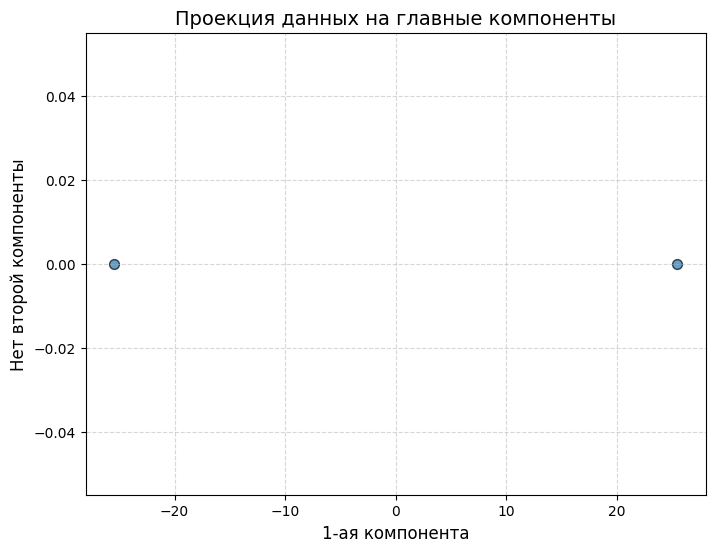

In [ ]:
Y = Matrix([[14, 88], [13, 37]])
Y_proj, explained_var, _ = pca(Y, k=None, threshold=0.95)
fig = plot_pca_projection(X_proj)

display(fig)

#**Среднеквадратическая ошибка восстановления данных**

In [ ]:
def reconstruction_error(X_orig: Matrix, X_recon: Matrix) -> float:
    # Вычисляет среднеквадратическую ошибку (MSE) между исходными и восстановленными данными.
    # Проверка совпадения размеров матриц
    if X_orig.rows != X_recon.rows or X_orig.cols != X_recon.cols:
        raise ValueError("Матрицы X_orig и X_recon должны иметь одинаковые размеры")

    n, m = X_orig.rows, X_orig.cols
    total_error = 0.0

    # Поэлементное вычисление суммы квадратов ошибок
    for i in range(n):
        for j in range(m):
            diff = X_orig[i][j] - X_recon[i][j]
            total_error += diff ** 2

    # Вычисление MSE
    mse = total_error / (n * m)
    return round(mse, 6)

#**Проверка MSE**

In [ ]:
# 1. Создаем данные
X = Matrix([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])
X_centered = center_data(X)

C = covariance_matrix(X_centered)

eigenvalues = find_eigenvalues(C)
eigenvectors = find_eigenvectors(C, eigenvalues)
# 2. Применяем PCA
X_proj, _, W = pca(X)

# 3. Восстанавливаем данные: X_recon = X_proj * W^T + mean
W_T = W.transpose_data()
X_recon = X_proj.multiply(W_T)

# Добавляем средние значения
mean = [sum(row[j] for row in X.data) / X.rows for j in range(X.cols)]
mean_matrix = Matrix([[mean[j] for j in range(X.cols)] for _ in range(X.rows)])
X_recon = X_recon.add(mean_matrix)

# 4. Проверяем MSE
error = reconstruction_error(X, X_recon)
print(f"MSE: {error:.6f}")

MSE: 0.000000


#**Обработка пропущенных значений**

In [ ]:
def handle_missing_values(X: Matrix) -> Matrix:
    # Заменяет пропущенные значения (NaN) в матрице на средние значения столбцов.
    filled_data = [row.copy() for row in X.data]
    n, m = X.rows, X.cols

    # Вычисляем средние значения для каждого столбца (игнорируя NaN)
    column_means = []
    for j in range(m):
        column_values = []
        for i in range(n):
            val = filled_data[i][j]
            if not isnan(val):
                column_values.append(val)

        if not column_values:
            raise ValueError(f"Столбец {j} полностью состоит из NaN")

        mean = sum(column_values) / len(column_values)
        column_means.append(mean)

    # Заменяем NaN на средние значения
    for i in range(n):
        for j in range(m):
            if isnan(filled_data[i][j]):
                filled_data[i][j] = column_means[j]

    return Matrix(filled_data)

#**Пример обработки**

In [ ]:
X = Matrix([
    [52.0, float('NaN'), 3.0],
    [float('NaN'), 11.0, 3.0],
    [7.0, 63.0, float('NaN')]
])

X_filled = handle_missing_values(X)
print(X)
print()
print(X_filled)

52.0000	nan	3.0000
nan	11.0000	3.0000
7.0000	63.0000	nan

52.0000	37.0000	3.0000
29.5000	11.0000	3.0000
7.0000	63.0000	3.0000


#**Исследования влияния шума на PCA**

In [ ]:
def _normal_distribution(mu=0, sigma=1):
  """Генератор нормального распределения"""
  while True:
    u1 = random.random()
    u2 = random.random()
    # Применяем формулу Бокса-Мюллера для получения нормального распределения
    z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2 * math.pi * u2)
    yield z0 * sigma + mu

def add_noise_and_compare(X: 'Matrix', noise_level: float = 0.1) -> Dict[str, Any]:
  # PCA для исходных данных
  X_centered = center_data(X)
  C = covariance_matrix(X_centered)
  eigenvalues_orig = find_eigenvalues(C)
  X_proj_orig, var_orig, _ = pca(X, k=None)
  fig_orig = plot_pca_projection(X_proj_orig)

  # Генерация шума
  gen = _normal_distribution()
  # Список для хранения шума по каждому столбцу
  noise_data = []
  for column in range(X.cols):
    # Извлекаем столбец как матрицу (вектор-столбец)
    col_data = Matrix([[X[rows][column]] for rows in range(X.rows)])
    std = col_data._std()
    # Генерируем шум для каждой строки с учетом уровня шума и std
    noise = [next(gen) * noise_level * std for _ in range(X.rows)]
    noise_data.append(noise)

  noise_data = Matrix(noise_data)
  X_noise = noise_data.transpose_data()

  X_centered_noise = center_data(X_noise)
  C_noise = covariance_matrix(X_centered_noise)
  eigenvalues_noise = find_eigenvalues(C_noise)
  X_proj_noise, var_noisy, _ = pca(X_noise, k=None)
  fig_noise = plot_pca_projection(X_proj_noise)

  return {
      # Исходные данные
      "original": {
          "eigenvalues": eigenvalues_orig,
          "explained_var": [explained_variance_ratio(eigenvalues_orig, k+1)
                          for k in range(len(eigenvalues_orig))],
          "plot": fig_orig
      },
      # Шум
      "noisy": {
          "eigenvalues": eigenvalues_noise,
          "explained_var": [explained_variance_ratio(eigenvalues_noise, k+1)
                          for k in range(len(eigenvalues_noise))],
          "plot": fig_noise
      },
      # Различия
      "differences": {
          "eigenvalues": [abs(e1 - e2) for e1, e2 in
                          zip(eigenvalues_orig, eigenvalues_noise)],
          "explained_var": abs(var_orig - var_noisy)
      }
  }

#**Визуализация данных**

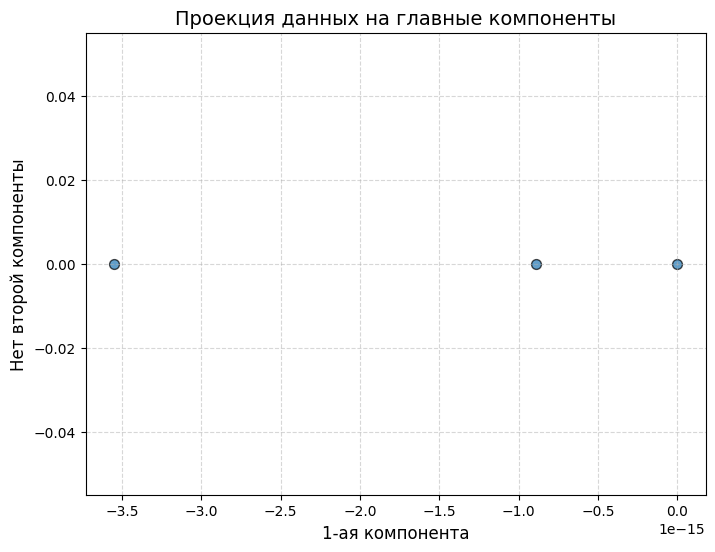

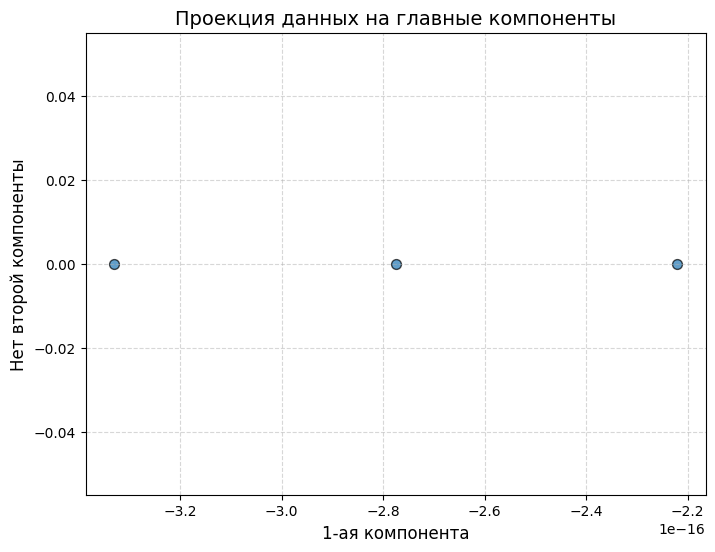

Собственные значения (исходные данные): [3220.345062, 79.988271, 0.0]
Собственные значения (шум): [188.939116, 29.655865, 0.0]
Разница в дисперсии: 0.11142938739223074


In [ ]:
F = Matrix([[14, 88, 99], [13, 37, 44], [33, 22, 11]])
results = add_noise_and_compare(F, noise_level=0.2)

display(results["original"]["plot"])
display(results["noisy"]["plot"])
print("Собственные значения (исходные данные):", results["original"]["eigenvalues"])
print("Собственные значения (шум):", results["noisy"]["eigenvalues"])
print("Разница в дисперсии:", results["differences"]["explained_var"])

#**Применение РСА к реальному датасету**

In [ ]:
def load_csv_to_matrix(file_path: str, has_header: bool = True) -> Matrix:
  """Загружает CSV-файл в объект Matrix"""
  data = []
  with open(file_path, 'r', encoding='utf-8') as f:
      reader = csv.reader(f)
      if has_header:
          next(reader)
      for row in reader:
          try:
              # Преобразуем все значения в float
              float_row = [float(x) for x in row]
              data.append(float_row)
          except ValueError as e:
              raise ValueError(f"Ошибка преобразования данных в float: {row}") from e
  return Matrix(data)

def apply_pca_to_csv(file_path: str, k: int, has_header: bool = True) -> Tuple[Matrix, float]:
    # Загрузка данных
    try:
        X = load_csv_to_matrix(file_path, has_header)
    except FileNotFoundError:
        raise FileNotFoundError(f"Файл {file_path} не найден")

    # Применение PCA
    X_proj, explained_var, _ = pca(X, k=k)

    return X_proj, explained_var